In [ ]:
import pkg_resources
import sys
import subprocess

required = {"PyPDF2", "sentence_transformers", "umap-learn", "hdbscan"}
sys_has = {pkg.key for pkg in pkg_resources.working_set}
diff = required - sys_has

if diff:
  python = sys.executable
  subprocess.check_call([python, '-m', 'pip', 'install', *diff], stdout=subprocess.DEVNULL)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import PyPDF2
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

In [ ]:
drive.mount("/content/drive/", force_remount=True)
# %cd "/content/drive/MyDrive/Topics /Research/AI Application"
%cd "/content/drive/MyDrive/AI Application"

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/13PT_4cR4fOTSOb8HVL9b8zZ9_eaCXXBM/AI Application


In [ ]:
%ls

 AIIB_all_projects_NLP_base2_fin.gsheet    'NLP Project Documents Analysis'/
 AIIB_all_projects_NLP_base2_fin.xlsx       project_list/
 archive/                                   report/
'NLP_project_document_analysis (1).ipynb'


In [ ]:
project_list = pd.read_excel("AIIB_all_projects_NLP_base2_fin.xlsx", sheet_name="project_list")
sdg_align    = pd.read_excel("AIIB_all_projects_NLP_base2_fin.xlsx", sheet_name="SDG_alignemtns_fin")
project_sum  = pd.read_excel("AIIB_all_projects_NLP_base2_fin.xlsx", sheet_name="project_summary")

print(f"Sizes: {project_list.shape}, {sdg_align.shape}, {project_sum.shape}")

Sizes: (284, 11), (284, 30), (284, 4)


In [ ]:
combine_align_sum = sdg_align.merge(project_sum, how="outer", left_index=True, right_index=True)

In [ ]:
nlp_frame = pd.DataFrame()
nlp_frame["text"] = combine_align_sum["Project Summary"].copy()
nlp_frame.dropna(inplace=True)
nlp_frame

text
0    OFFICIAL USE ONLY\n Project Summary Informatio...
1    OFFICIAL USE ONLY\n Project Summary Informatio...
2    OFFICIAL USE ONLY\n Project Summary Informatio...
3    Project Summary Information Template. Sovereig...
4    OFFICIAL USE ONLY\n Project Summary Informatio...
..                                                 ...
279  Myingyan 225 MW\n Combined Cycle Gas\n Turbine...
280  1\n Project Summary Information (PSI)\n Report...
281  1\n *OFFICIAL USE ONLY\n Project Summary Infor...
282  OFFICIAL USE ONLY\n Project Summary Informatio...
283  Tajikistan: Dushanbe-Uzbekistan Border Road Im...

[284 rows x 1 columns]

In [ ]:
import string
import re
import nltk

def remove_punc(text):
  out = "".join([i for i in text if i not in string.punctuation])
  return out

def tokenize(text):
  tokens = re.split("W+", text)
  return tokens

nlp_frame["text"] = nlp_frame["text"].apply(lambda x : remove_punc(x))
nlp_frame["text"] = nlp_frame["text"].apply(lambda x : x.lower())
nlp_frame["text"] = nlp_frame["text"].str.replace("official use only", "") # A couple of repeated phrases throughout the document that likely need to be parsed out, REVISIT
nlp_frame["text"] = nlp_frame["text"].str.replace("\n", "")
nlp_frame["tokens"] = nlp_frame["text"].apply(lambda x : tokenize(x))

nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words("english")
porter_stemmer = nltk.stem.porter.PorterStemmer()
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

def remove_stopwords(text):
  out = [i for i in text if i not in stopwords]
  return out

def stem(text):
  out = [porter_stemmer.stem(i) for i in text]
  return out

def lemmatize(text):
  out = [wordnet_lemmatizer.lemmatize(i) for i in text]
  return out

nlp_frame["tokens"] = nlp_frame["tokens"].apply(lambda x : remove_stopwords(x))
nlp_frame["tokens"] = nlp_frame["tokens"].apply(lambda x : stem(x))
nlp_frame["tokens"] = nlp_frame["tokens"].apply(lambda x : lemmatize(x))

mapping = {
    "green infrastructure": ["green building solutions"]
}

classes = ["green infrastructure", "private capital mobilization", "technology enabled infrastructure", "connectivity and regional cooperation", "multi sector"]
thematic_target_arr = ["thematic_target_gi", "thematic_target_pcm", "thematic_target_tei", "thematic_target_crc", "thematic_target_ms"]
nlp_frame[thematic_target_arr] = np.zeros((nlp_frame.shape[0], len(classes)))
nlp_frame["unique_thematic_id"] = -1
for idx, c in enumerate(classes):
  nlp_frame.loc[nlp_frame["text"].str.contains(c), thematic_target_arr[idx]] = 1
  nlp_frame.loc[nlp_frame["text"].str.contains(c), "unique_thematic_id"] = idx
nlp_frame["sector"] = combine_align_sum["SECTOR"].copy()
nlp_frame

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


text  \
0     project summary information date of document ...   
1     project summary information date of document ...   
2     project summary information date of document ...   
3    project summary information template sovereign...   
4     project summary information project name surk...   
..                                                 ...   
279  myingyan 225 mw combined cycle gas turbine ccg...   
280  1 project summary information psi report no 00...   
281  1  project summary information date of documen...   
282   project summary information date of document ...   
283  tajikistan dushanbeuzbekistan border road impr...   

                                                tokens  thematic_target_gi  \
0    [ project summary information date of document...                 1.0   
1    [ project summary information date of document...                 1.0   
2    [ project summary information date of document...                 1.0   
3    [project summary information template sovereig...                 1.0   
4    [ project summary information project name sur...                 0.0   
..                                                 ...                 ...   
279  [myingyan 225 mw combined cycle gas turbine cc...                 0.0   
280  [1 project summary information psi report no 0...                 0.0   
281  [1  project summary information date of docume...                 0.0   
282  [ project summary information date of document...                 0.0   
283  [tajikistan dushanbeuzbekistan border road imp...                 0.0   

     thematic_target_pcm  thematic_target_tei  thematic_target_crc  \
0                    0.0                  0.0                  0.0   
1                    0.0                  0.0                  0.0   
2                    0.0                  0.0                  1.0   
3                    1.0                  0.0                  0.0   
4                    1.0                  0.0                  0.0   
..                   ...                  ...                  ...   
279                  0.0                  0.0                  0.0   
280                  0.0                  0.0                  0.0   
281                  0.0                  0.0                  0.0   
282                  0.0                  0.0                  0.0   
283                  0.0                  0.0                  0.0   

     thematic_target_ms  unique_thematic_id     sector  
0                   0.0                   0     Energy  
1                   0.0                   0      Urban  
2                   0.0                   3      Urban  
3                   0.0                   1     Energy  
4                   0.0                   1     Energy  
..                  ...                 ...        ...  
279                 0.0                  -1     Energy  
280                 0.0                  -1  Transport  
281                 0.0                  -1  Transport  
282                 0.0                  -1     Energy  
283                 0.0                  -1  Transport  

[284 rows x 9 columns]

In [ ]:
nlp_frame["file"] = combine_align_sum["PROJECT NAME_x"].copy()
nlp_frame["unmarked"] = np.where(nlp_frame[thematic_target_arr].sum(axis=1) == 0, -1, 0)
unmarked_files = nlp_frame.loc[nlp_frame["unmarked"] == -1, "file"].values
len(unmarked_files)

218

In [ ]:
token_start = [sentence[0].find("alignment with aiibs thematic priorities") for sentence in nlp_frame["tokens"].values]
thematic_keys = [sentence[0][token_start[idx] + 29:token_start[idx]+100] for idx, sentence in enumerate(nlp_frame["tokens"].values)]

missing_keys = pd.DataFrame()
missing_keys["unmarked"] = nlp_frame["unmarked"].copy()
missing_keys["key"] = thematic_keys
missing_keys["file"] = combine_align_sum["PROJECT NAME_x"].iloc[missing_keys.index].values
missing_keys[missing_keys["unmarked"] == -1]

unmarked                                                key  \
7          -1   we arewhat we dohow we workwork with usprint ...   
10         -1   date of document preparationupdating 060523 1...   
12         -1   priorities covid19 crisis recovery facility c...   
13         -1   date of document preparation may 05 2023 proj...   
16         -1  y information date of document preparation may...   
..        ...                                                ...   
279        -1  le gas turbine ccgt power plant project myanma...   
280        -1  n psi report no 000013 project name sultanate ...   
281        -1  on date of document preparation september 23 2...   
282        -1   date of document updating sep 8 2020 project ...   
283        -1  n border road improvement project cofinanced w...   

                                                  file  
7    Bangladesh: Bangladesh Sustainable Economic Re...  
10   Philippines: Philippines – Inclusive Finance D...  
12   Indonesia: Boosting Productivity through Human...  
13       Viet Nam: Viet Nam Gia Lai Wind Power Project  
16                     Hong Kong, China: Project Ocean  
..                                                 ...  
279  Myanmar: Myingyan 225 MW Combined Cycle Gas Tu...  
280  Oman: Duqm Port Commercial Terminal and Operat...  
281  Pakistan: National Motorway M-4 (Shorkot-Khane...  
282           Pakistan: Tarbela 5 Hydropower Extension  
283  Tajikistan: Dushanbe-Uzbekistan Border Road Im...  

[218 rows x 3 columns]

In [ ]:
nlp_frame_clean = nlp_frame[nlp_frame[thematic_target_arr].sum(axis=1) != 0]

In [ ]:
def to_sentence(text):
  return " ".join(text)

bert = SentenceTransformer("bert-base-nli-mean-tokens", device="cuda")

nlp_frame_clean["sentence"] = nlp_frame_clean["tokens"].apply(lambda x : to_sentence(x))
embedding = bert.encode(nlp_frame_clean["sentence"].values)
embedding.shape

(66, 768)

In [ ]:
pa_articles = pd.read_excel("AIIB_all_projects_NLP_base2_fin.xlsx", sheet_name="pa_articles")
pa_articles.dropna(inplace=True)
pa_articles

Articles                                            Content
0     Overview  THE PARIS AGREEMENT\nThe Parties to this Agree...
1   Article 1   For the purpose of this Agreement, the definit...
2    Article 2  1. This Agreement, in enhancing the implementa...
3    Article 3  As nationally determined contributions to the ...
4    Article 4  1. In order to achieve the long-term temperatu...
5    Article 5  1. Parties should take action to conserve and ...
6    Article 6  1. Parties recognize that some Parties choose ...
7    Article 7  1. Parties hereby establish the global goal on...
8    Article 8  Article 8\n1. Parties recognize the importance...
9    Article 9  Article 9\n1. Developed country Parties shall ...
10  Article 10  Article 10\n1. Parties share a long-term visio...
11  Article 11  Article 11\n1. Capacity-building under this Ag...
12  Article 12  Article 12\nParties shall cooperate in taking ...
13  Article 13  Article 13\n1. In order to build mutual trust ...
14  Article 14  Article 14\n1. The Conference of the Parties s...
15  Article 15  Article 15\n1. A mechanism to facilitate imple...
16  Article 16  Article 16\n1. The Conference of the Parties, ...
17  Article 17  Article 17\n1. The secretariat established by ...
18  Article 18  Article 18\n1. The Subsidiary Body for Scienti...
19  Article 19  Article 19\n1. Subsidiary bodies or other inst...
20  Article 20  Article 20\n1. This Agreement shall be open fo...
21  Article 21  Article 21\n1. This Agreement shall enter into...
22  Article 22  Article 22\nThe provisions of Article 15 of th...
23  Article 23  Article 23\n1. The provisions of Article 16 of...

In [ ]:
files = combine_align_sum["PROJECT NAME_x"].values

def cosine(u, v):
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

summary = pd.DataFrame()
data_mat = []
for i in range(0, nlp_frame_clean.shape[0]):
  data_mat.append((files[i], cosine(embedding[3], embedding[i])))
summary[["file", "cosine-sim"]] = data_mat
summary.sort_values(by="cosine-sim", ascending=False)

file cosine-sim
3                        Brazil: BTG Green On-Lending        1.0
48         Türkiye: Antalya Airport Expansion Project   0.876977
43  India: Fourth Partner Energy Distributed Solar...   0.844099
29  Bangladesh: Rampura-Amulia-Demra (RAD) Express...   0.843927
63               India: FPL Open Access Solar Project   0.835043
..                                                ...        ...
65  Lao PDR: Monsoon 600 MW Cross-border Wind Powe...   0.636656
6   India: Manipur Urban Road, Drainage and Asset ...    0.61916
64                        Multicountry: Rakiza Fund I   0.614717
12  Indonesia: Boosting Productivity through Human...   0.608482
18  Philippines: Laguna Lakeshore Road Network (Ph...   0.592809

[66 rows x 2 columns]

In [ ]:
pa_articles["text"]   = pa_articles["Content"].apply(lambda x : remove_punc(x))
pa_articles["text"]   = pa_articles["text"].apply(lambda x : x.lower())
pa_articles["text"]   = pa_articles["text"].str.replace("\n", "")
pa_articles["tokens"] = pa_articles["text"].apply(lambda x : tokenize(x))
pa_articles["tokens"] = pa_articles["tokens"].apply(lambda x : remove_stopwords(x))
pa_articles["tokens"] = pa_articles["tokens"].apply(lambda x : stem(x))
pa_articles["tokens"] = pa_articles["tokens"].apply(lambda x : lemmatize(x))

pa_embeddings = bert.encode(pa_articles["Content"].values)
nlp_frame["sentence"] = nlp_frame["tokens"].apply(lambda x : to_sentence(x))
embedding = bert.encode(nlp_frame["sentence"].values)

article_document_sim_mat = []
summary_pa = pd.DataFrame()

for idx, pa_embedding in enumerate(pa_embeddings):
  for idy, document in enumerate(embedding):
    article_document_sim_mat.append((pa_articles["Articles"].iloc[idx], files[idy], cosine(pa_embedding, document)))
summary_pa[["pa article num", "document", "cosine-sim"]] = article_document_sim_mat
summary_pa.sort_values(by="cosine-sim", ascending=False)

pa article num                                           document  \
745       Article 2     Maldives: Greater Malé Waste-to-Energy Project   
1429      Article 5  Cambodia: Climate Adaptive Irrigation and Sust...   
2629      Article 9  Fiji: Sustainable and Resilient Recovery Progr...   
2689      Article 9  India: Creating a Coordinated and Responsive I...   
2600      Article 9  Multicountry: Catalyst MENA Climate Fund 2 (“C...   
...             ...                                                ...   
5656     Article 19  Bangladesh: Natural Gas Infrastructure and Eff...   
5661     Article 19      India: Bangalore Metro Rail Project - Line R6   
5645     Article 19           India: Madhya Pradesh Rural Connectivity   
5665     Article 19  Indonesia: Regional Infrastructure Development...   
3657     Article 12           India: Madhya Pradesh Rural Connectivity   

     cosine-sim  
745    0.795477  
1429   0.792883  
2629   0.783171  
2689    0.78106  
2600    0.77966  
...         ...  
5656   0.181423  
5661   0.178807  
5645   0.173494  
5665   0.173278  
3657   0.162484  

[6816 rows x 3 columns]

In [ ]:
summary_pa.groupby(by="document").mean()

cosine-sim
document                                                      
Alcazar Energy Partners II (“AEP-II”)                 0.570375
Azerbaijan: Republic of Azerbaijan COVID-19 Act...    0.472449
Azerbaijan: Trans Anatolian Natural Gas Pipelin...    0.541135
Bangladesh: Bangladesh Bhola IPP                      0.411154
Bangladesh: Bangladesh Integrated Solid Waste M...    0.575636
...                                                        ...
Uzbekistan: UzPSB Energy and Water Efficiency, ...    0.552162
Viet Nam: Dak Lak Wind Power Project                  0.455254
Viet Nam: Dakdrinh 125MW Hydropower Plant             0.472704
Viet Nam: VP Bank COVID-19 Response Facility          0.522722
Viet Nam: Viet Nam Gia Lai Wind Power Project         0.487270

[282 rows x 1 columns]

### Word Frequency Analysis

In [ ]:
import re
word_map = ["paris agreement", "climate adaptation", "climate mitigation", "climate change"]

freq_mat = []

for idx, sentence in enumerate(nlp_frame["sentence"].values):
  freq_mat.append([sentence.count(word) for word in word_map])
nlp_frame[word_map] = freq_mat

In [ ]:
nlp_frame.loc[nlp_frame["paris agreement"] > 0, "file"]

16                       Hong Kong, China: Project Ocean
24     China: Ningbo Green and Low-Carbon Port Develo...
39                  China: Chongho Bridge Green Facility
40     Jordan: Additional Financing for Inclusive, Tr...
57                     Bangladesh: Unique Meghnaghat IPP
81     Thailand: U-Tapao International Airport Expans...
131    Jordan: Inclusive Transparent and Climate Resp...
217    India: L&amp;T- Sustainable Infrastructure on-...
220    India: Tata Cleantech Sustainable Infrastructu...
224            Multicountry: Asia Climate Bond Portfolio
Name: file, dtype: object

In [ ]:
nlp_frame_clean_noidx = nlp_frame_clean.reset_index(drop=True)

In [ ]:
indices = []

for key, val in nlp_frame_clean_noidx.groupby(by="sector", sort=False).groups.items():
  indices.extend(val.values.tolist())

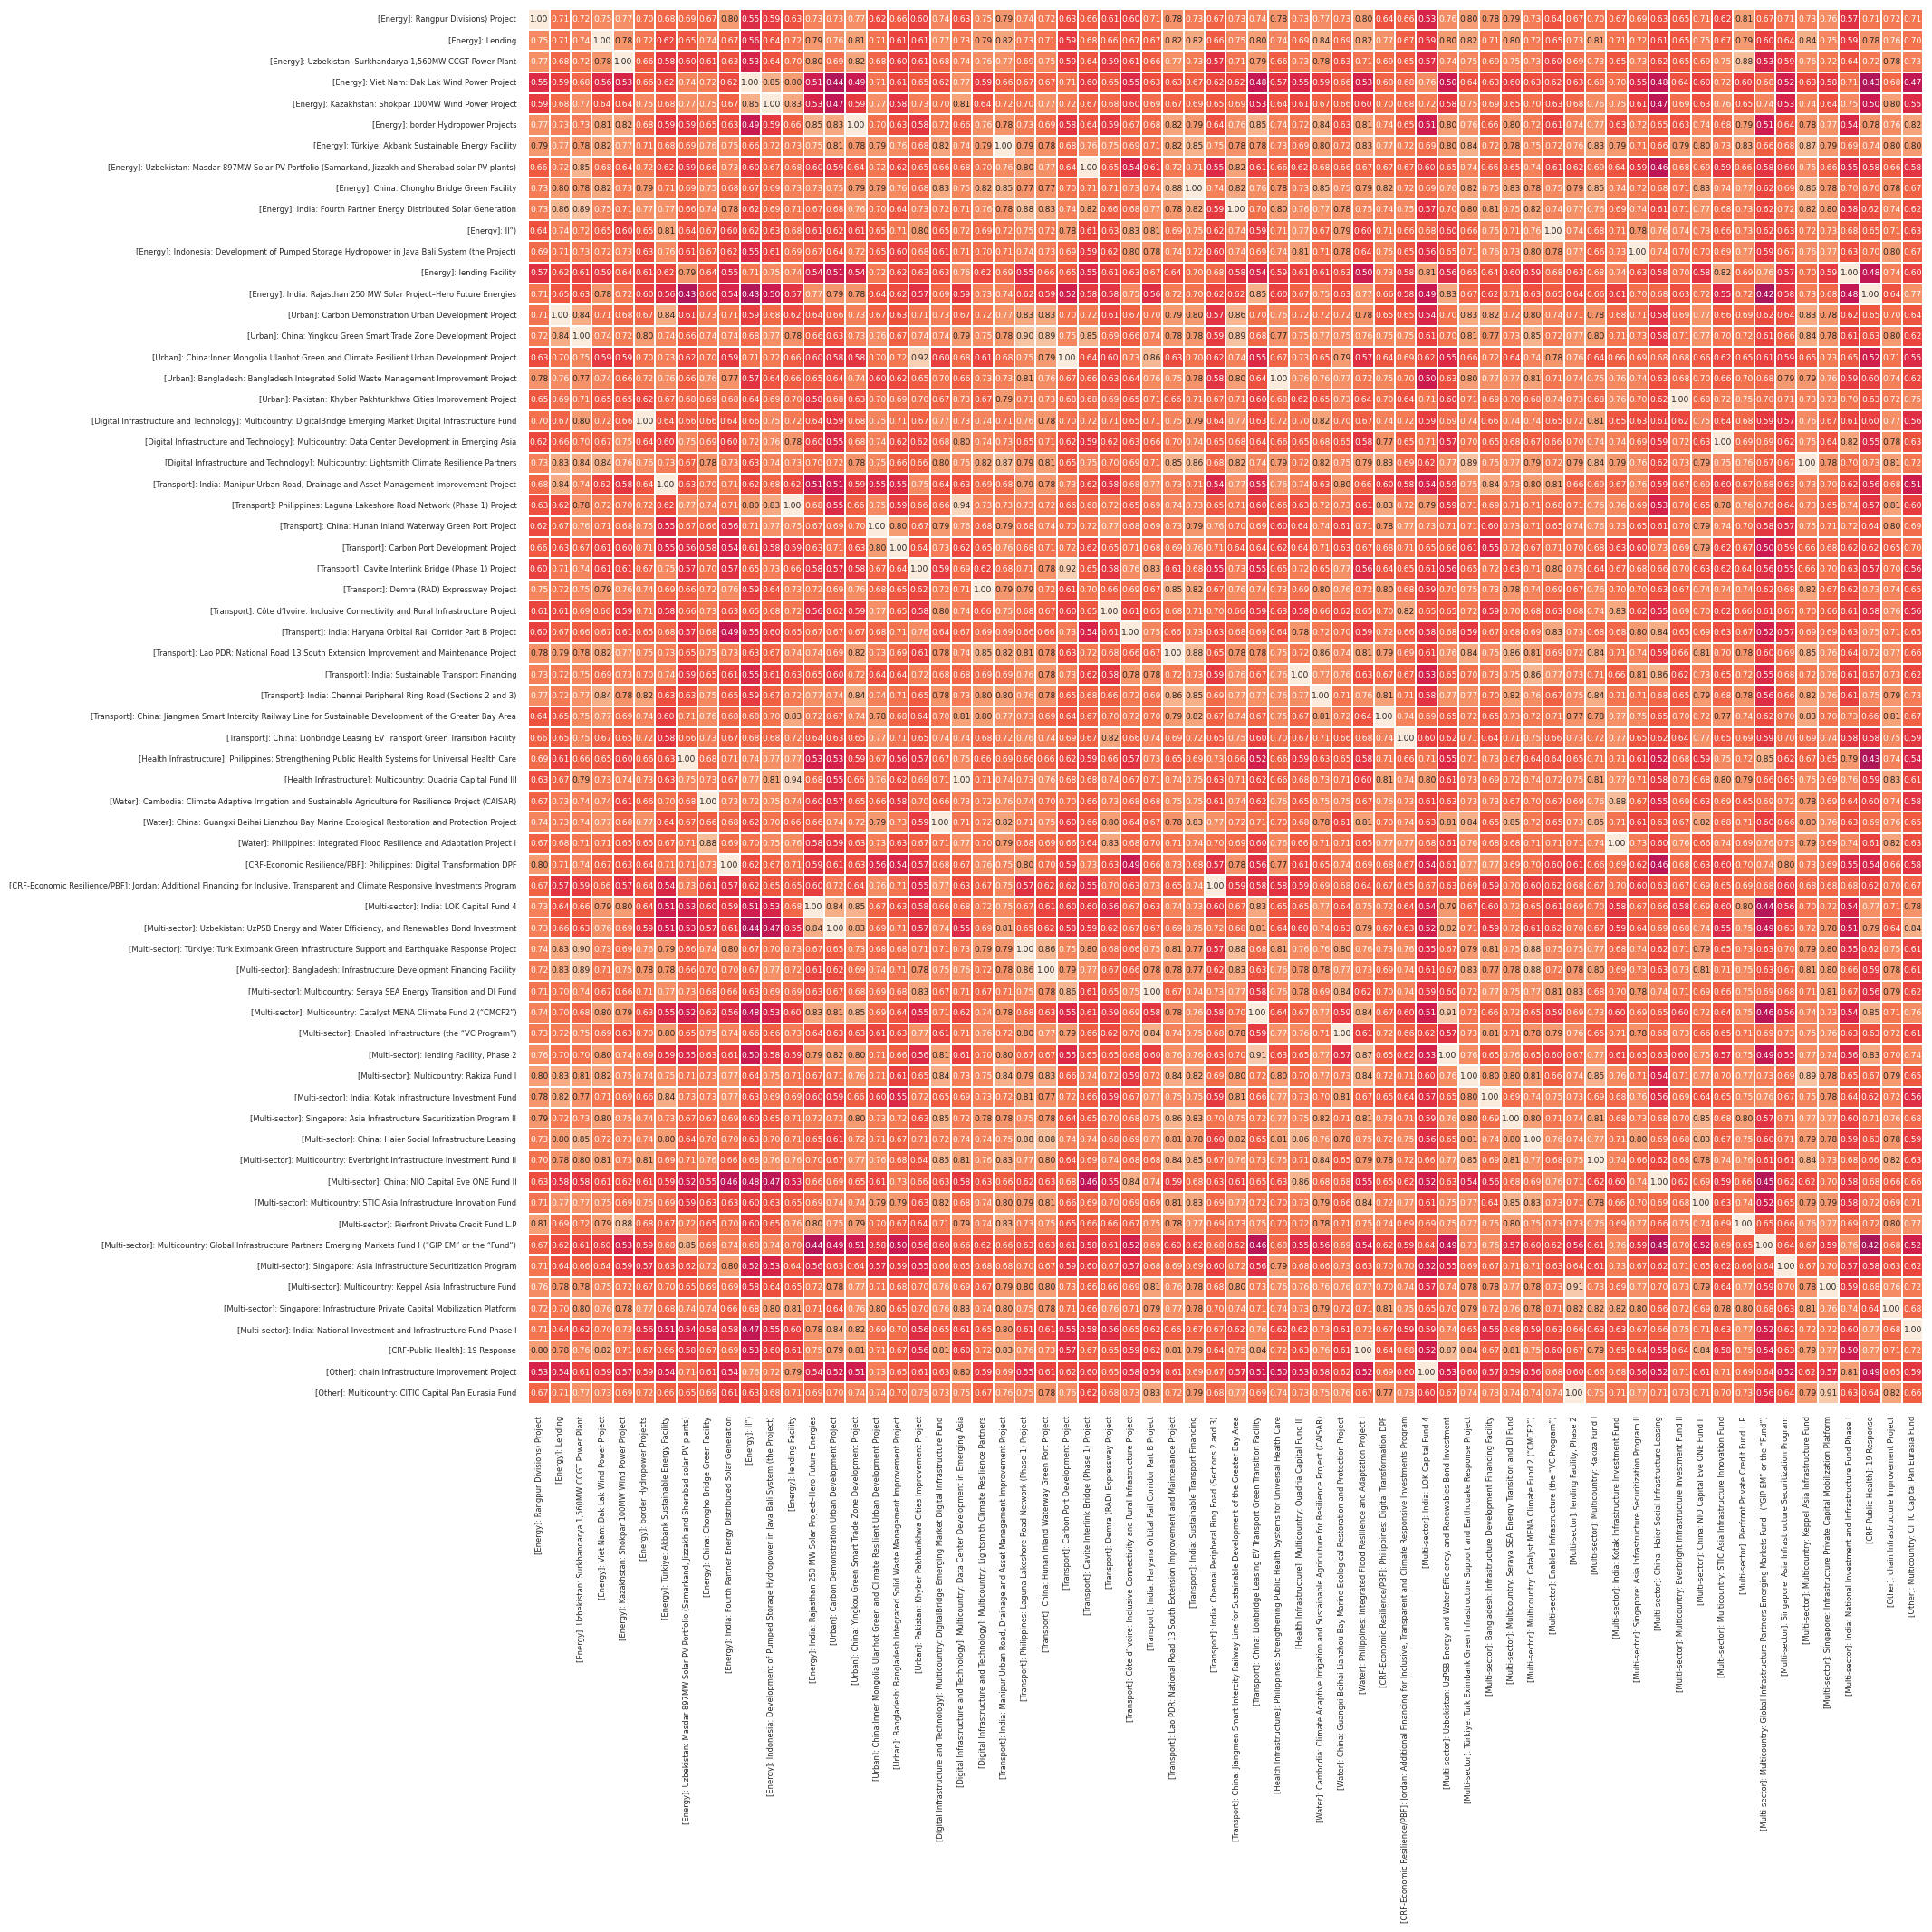

In [ ]:
import seaborn as sns

sim_mat = []

for i in range(nlp_frame_clean_noidx.shape[0]):
  temp = []
  for j in range(nlp_frame_clean_noidx.shape[0]):
    temp.append(cosine(embedding[i], embedding[j]))
  sim_mat.append(temp)

sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale=0.55)
ids = [file.split("-")[min(2, len(file.split("-")) - 1)] for file in nlp_frame_clean_noidx["file"]]

sectors = nlp_frame_clean_noidx["sector"].values
sim_mat_sort, ids_sort, sectors_sort = [], [], []
for index in indices:
  sim_mat_sort.append(sim_mat[index])
  ids_sort.append(ids[index])
  sectors_sort.append(sectors[index])

for i in range(0, len(ids_sort)):
  ids_sort[i] = "[" + sectors_sort[i] + "]: " + ids_sort[i]

# https://seaborn.pydata.org/tutorial/color_palettes.html
sns.heatmap(sim_mat_sort, square=True, vmin=0, vmax=1, annot=True, fmt=".2f", xticklabels=ids_sort, yticklabels=ids_sort, linewidths=0.18, cbar=False);

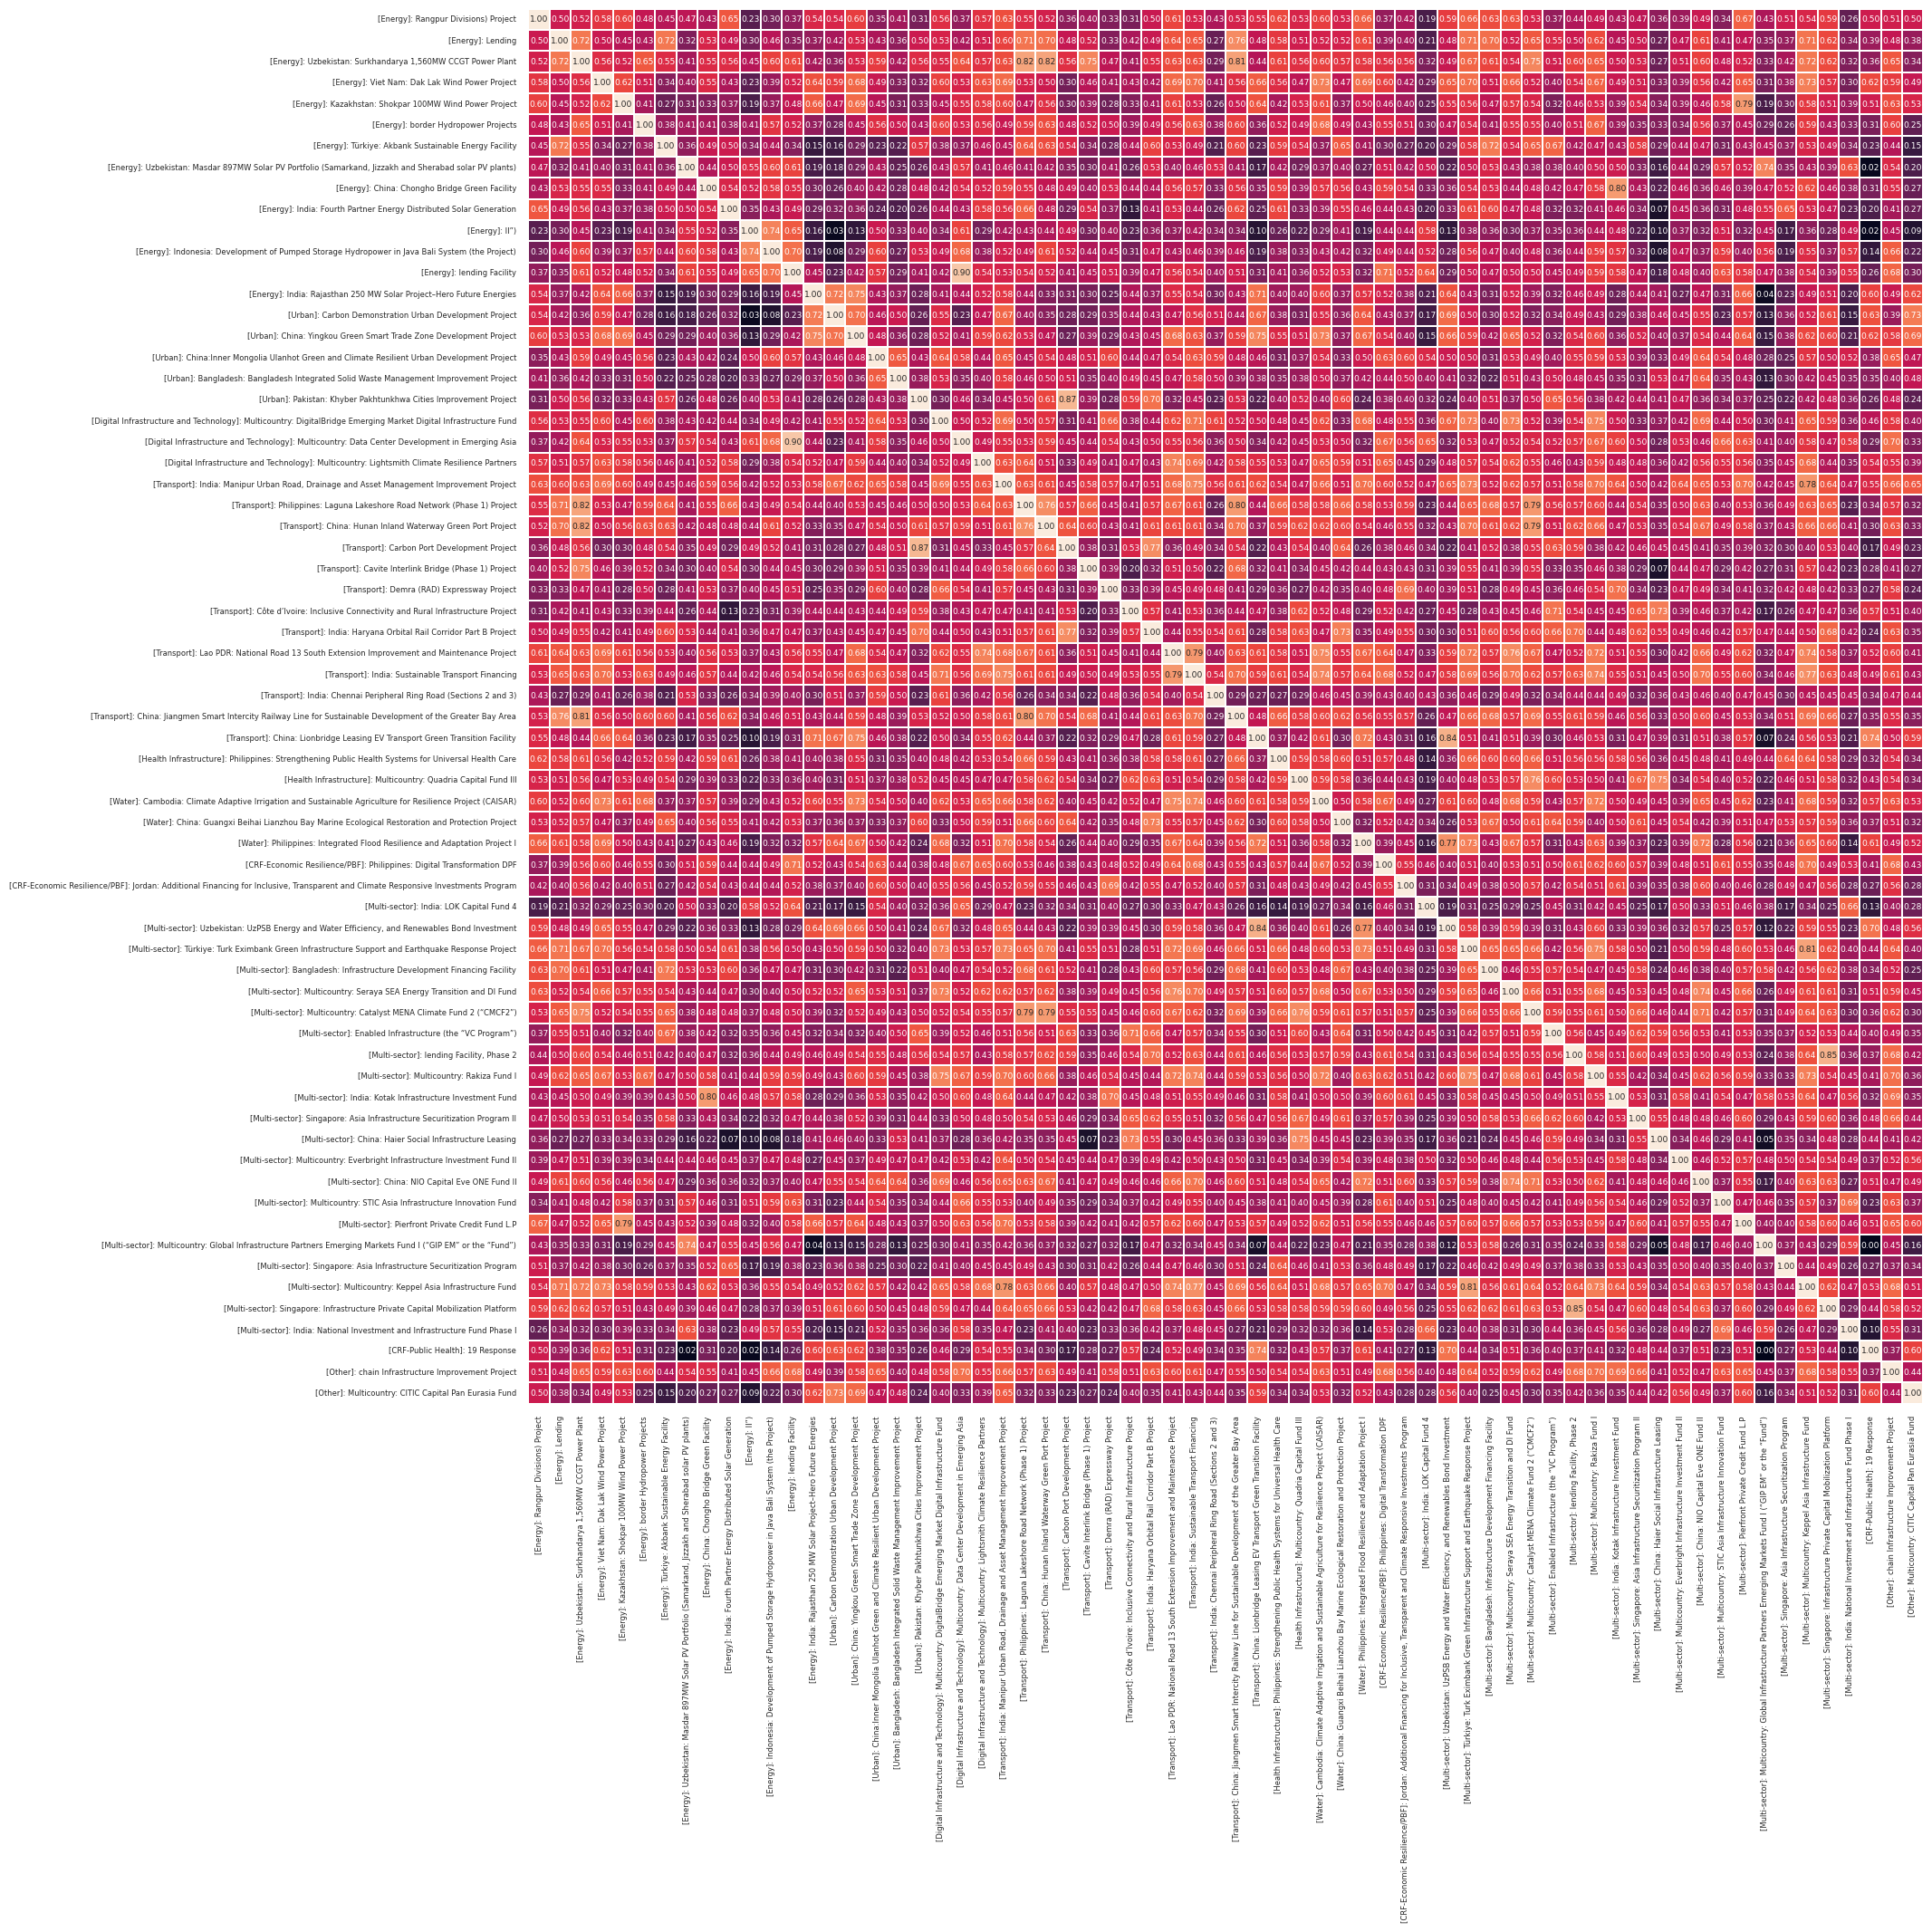

In [ ]:
normalize = (sim_mat - np.min(sim_mat)) / (np.max(sim_mat) - np.min(sim_mat))
sns.heatmap(normalize, square=True, vmin=0, vmax=1, annot=True, fmt=".2f", xticklabels=ids_sort, yticklabels=ids_sort, linewidths=0.18, cbar=False);

In [ ]:
import umap

umap_embeddings = umap.UMAP(n_neighbors=7, n_components=3, metric="cosine", random_state=42).fit_transform(embedding)

In [ ]:
clusters = hdbscan.HDBSCAN(min_cluster_size=2, metric="euclidean", cluster_selection_method="eom").fit(umap_embeddings)

In [ ]:
clusters = clusters.labels_

In [ ]:
umap_embeddings.shape

(284, 3)

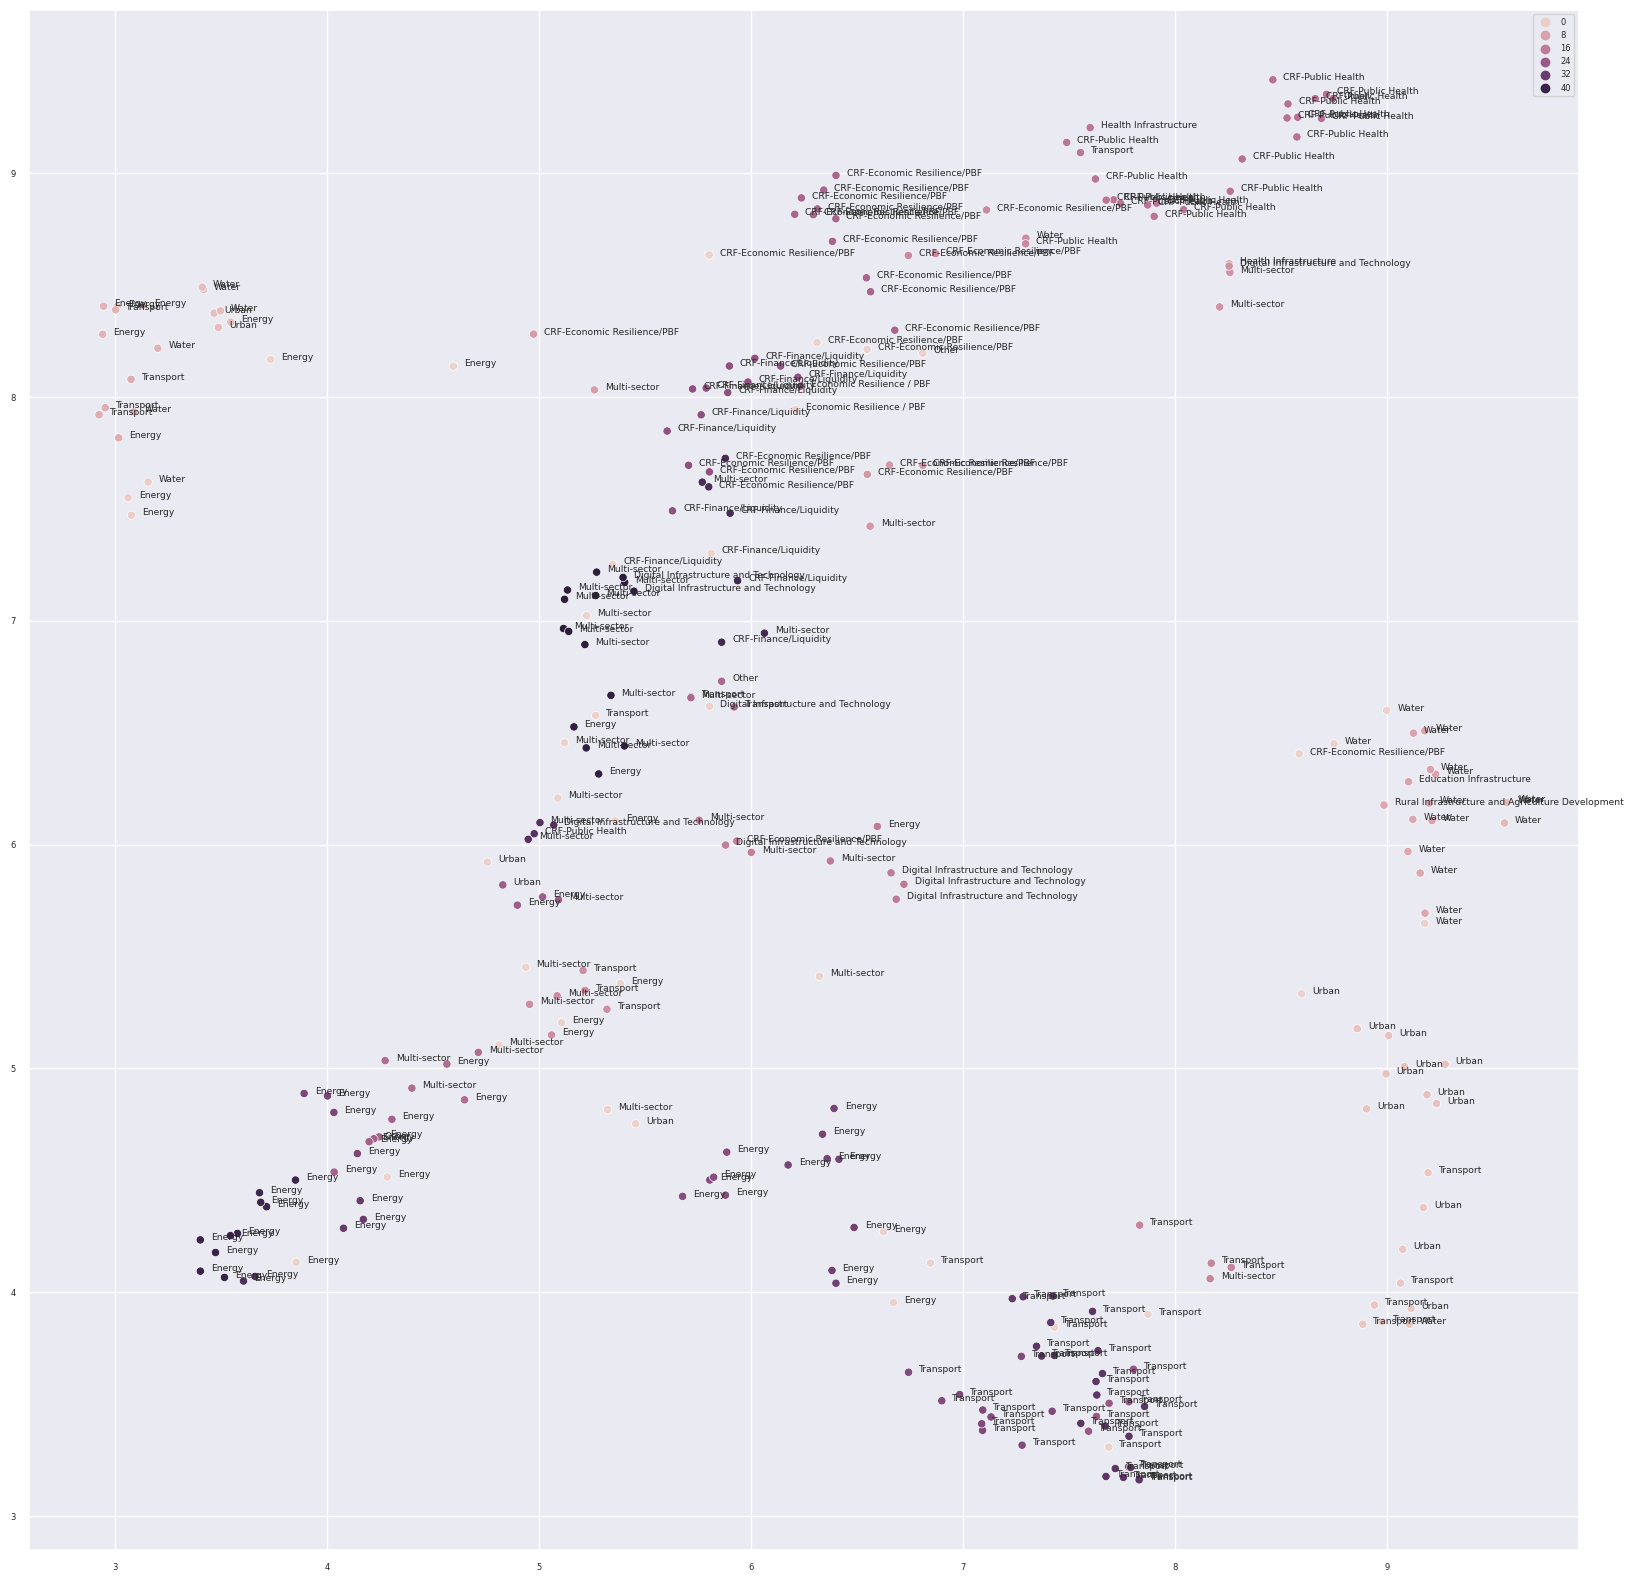

In [ ]:
ax = sns.scatterplot(data=umap_embeddings, x=umap_embeddings[:,0], y=umap_embeddings[:,1], hue=clusters); # Set up to include label for some unique identifier from metadata

def label_points(x, y, val, ax):
  a = pd.concat({'x':x, 'y':y, 'val':val}, axis=1)
  for idx, point in a.iterrows():
    ax.text(point['x']+0.05, point['y'], str(point['val']))
label_points(pd.Series(umap_embeddings[:,0]), pd.Series(umap_embeddings[:,1]), nlp_frame["sector"], plt.gca())

In [ ]:
nlp_frame.to_csv("output.csv")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

X,y = embedding, nlp_frame_clean[thematic_target_arr].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBClassifier

k_fold = KFold(n_splits=5)

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test   = X[test_index], y[test_index]

  model = XGBClassifier(alpha=1e-2)
  model.fit(X_train, y_train)

  print(f"Fold {i}, score: {model.score(X_test, y_test)}")

In [ ]:
X,y = umap_embeddings, nlp_frame_clean[thematic_target_arr].values

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test   = X[test_index], y[test_index]

  model = XGBClassifier(alpha=1e-2)
  model.fit(X_train, y_train)

  print(f"Fold {i}, score: {model.score(X_test, y_test)}")

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC

agg_score = []
for i, (train_index, test_index) in enumerate(k_fold.split(X)):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test   = X[test_index], y[test_index]

  model = MultiOutputClassifier(SVC(C=1000))
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)

  print(f"Fold {i}, score: {score}")
  agg_score.append(score)
print("Average:", np.mean(agg_score))

In [ ]:
agg_score = []
for i, (train_index, test_index) in enumerate(k_fold.split(X)):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test   = X[test_index], y[test_index]

  model = MultiOutputClassifier(SVC(C=1000, kernel="linear"))
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)

  print(f"Fold {i}, score: {score}")
  agg_score.append(score)
print("Average:", np.mean(agg_score))

In [ ]:
from sklearn.linear_model import LogisticRegression

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test   = X[test_index], y[test_index]

  model = MultiOutputClassifier(LogisticRegression(penalty="l1", solver="liblinear"))
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)

  print(f"Fold {i}, score: {score}")
  agg_score.append(score)
print("Average:", np.mean(agg_score))